# Reccomender system

Once we have our data base in vectorised form we can also provide a way to provide articles that are similar to the one that was given as an input. This can be useful for authors at it might point out articles that are related with their work and that they were not aware of. As a first attempt to solve this type of problem we can use cosine similarity.

The code contained here is basically the same contained in the module model.py

In [46]:
import pickle
import os
import re
import numpy as np
from random import shuffle
import shutil
from  urllib.request import urlopen

from utils import Config, read_clean, strip_extension

from sklearn.feature_extraction.text import TfidfVectorizer


In [47]:
with open(Config.tfidf,'rb') as file:
    tfidf=pickle.load(file)
with open(Config.vectorized_articles,'rb') as file:
    vectorized_articles=pickle.load(file)

In [3]:
X=vectorized_articles['X']

In [4]:
#Function that return the articles in the database X that are closer to the given article x based on cos similarity
def find_similar(X,x,how_many):
    cos_similarity=x.dot(X.transpose())
    cos_similarity=np.asarray(cos_similarity.todense())
    return np.argsort(-cos_similarity)[:,:how_many]

We can see an example on how this works on the first two articles of the database.

In [5]:
print(vectorized_articles['articles'][find_similar(X,X[0:2,:],10)])
print(vectorized_articles['links'][find_similar(X,X[0:2,:],10)])

[['2003.01771' '1902.08464' '1910.00583' '1807.09515' '0910.5001'
  '1901.07357' '2002.06177' '1904.01053' '1901.10728' '2002.05193']
 ['1908.02651' '2001.01266' '2002.08316' '1908.02640' '1907.00271'
  '1902.06655' '1906.09380' '1911.08356' '1906.00478' '2002.08161']]
[['http://arxiv.org/pdf/2003.01771v1' 'http://arxiv.org/pdf/1902.08464v3'
  'http://arxiv.org/pdf/1910.00583v2' 'http://arxiv.org/pdf/1807.09515v1'
  'http://arxiv.org/pdf/0910.5001v1' 'http://arxiv.org/pdf/1901.07357v1'
  'http://arxiv.org/pdf/2002.06177v3' 'http://arxiv.org/pdf/1904.01053v1'
  'http://arxiv.org/pdf/1901.10728v2' 'http://arxiv.org/pdf/2002.05193v2']
 ['http://arxiv.org/pdf/1908.02651v3' 'http://arxiv.org/pdf/2001.01266v2'
  'http://arxiv.org/pdf/2002.08316v1' 'http://arxiv.org/pdf/1908.02640v1'
  'http://arxiv.org/pdf/1907.00271v1' 'http://arxiv.org/pdf/1902.06655v1'
  'http://arxiv.org/pdf/1906.09380v1' 'http://arxiv.org/pdf/1911.08356v1'
  'http://arxiv.org/pdf/1906.00478v3' 'http://arxiv.org/pdf/2002

## Evaluation of the reccomender system

By looking the articles given by the reccomender system it can be seen that they seem to be very similar to the one given as an input. Anyhow we would like to have a more quantitative measurement on how good our reccomender system is. 

In general this is not an easy problem, as we do not know if the reccomended articles are relevant or not, as it would require to read the articles, which for large number of articles is clearly not feasible. One possible approach is then to consider as relevant all the articles that are cited by the paper that we are considering. Since it might be possible that not all the articles cited by artices in the database are also part of the database we will need to download the cited articles

Unfortunately most of the time cited articles are not on free acess and this would render it difficult to download them. For this reason we will only consider citations to arXiv articles, which we can easily download. The following approach, therefore, present evident limitations, which could be overcame or at least reduced with more accessible resources. 

Another point to be consider is that sometimes not all the articles that are being cited are relevant, these type of complications could be possibly be resolved through some data labeling, wich we will not perform here.

Let's therefore start by selecting a set of articles on which we will perform the analysis

In [6]:
with open(Config.metadata_db,'rb') as file:
    metadata_db=pickle.load(file)

txt_labels_train=[]

for article in metadata_db.keys():
    article_path=os.path.join(Config.txt_db,article+'.txt')
    if os.path.isfile(article_path):
        txt_labels_train.append(article)    

In [7]:
txts = os.listdir(Config.txt_db)
idxs=[strip_extension(txt) for txt in txts]

In [8]:
citations_db={}
for idx in txt_labels_train:
    with open(os.path.join(Config.txt_db,idx+'.txt'),'r') as file:
        article=file.read()
    citations=re.findall('arXiv:[0-9]+.[0-9]+|arXiv:[a-zA-Z-]+.[0-9]+|arXiv:[a-zA-Z-]+.[0-9]+.[0-9]',article)
    if len(citations)>=10:#We restrict to those papers that have a sufficent number of citations
        citations_db[idx]=citations[1:] # the first citation is generally the paper itself

In [9]:
len(citations_db)

1993

We can now see what the citations look like and save them.

In [10]:
{list(citations_db.keys())[0]: citations_db[list(citations_db.keys())[0]]}

{'0807.4730': ['arXiv:astro-ph/0701517',
  'arXiv:astro-ph/0101231',
  'arXiv:astro-ph/0206286',
  'arXiv:astro-ph/9807150',
  'arXiv:astro-ph/0406254',
  'arXiv:astro-ph/0701856',
  'arXiv:astro-ph/0504149',
  'arXiv:astro-ph/0109223',
  'arXiv:0705.1972',
  'arXiv:astro-ph/0201345',
  'arXiv:astro-ph/0402180',
  'arXiv:astro-ph/0512456',
  'arXiv:astro-ph/0206336',
  'arXiv:astro-ph/0106359',
  'arXiv:astro-ph/0405275',
  'arXiv:astro-ph/0702532',
  'arXiv:astro-ph/0410214',
  'arXiv:0707.4415',
  'arXiv:astro-ph/0106502',
  'arXiv:astro-ph/9902012',
  'arXiv:astro-ph/0103150',
  'arXiv:astro-ph/0106567',
  'arXiv:astro-ph/0002481',
  'arXiv:astro-ph/9906426',
  'arXiv:astro-ph/0010381',
  'arXiv:astro-ph/0103513',
  'arXiv:astro-ph/0608697',
  'arXiv:0712.1548']}

In [11]:
#Save the set of citations
with open(Config.citations_db,'wb') as file:
    pickle.dump(citations_db,file)

We can now download the articles. To do this we will tweak a bit the script download_to_text.py

In [12]:
#Compute lengths for downloading articles
length=0
for citations in citations_db.values():
    length=length+len(citations)

In [13]:
def get_id_url(citation):
    idx=citation[citation.rfind(':')+1:].split('v')[0]
    control=idx.rfind('/')
    if control!=-1:
        idx=idx[control+1:]
    url='http://export.'+citation.replace(':','.org/pdf/')+'.pdf'
    return idx,url.lower()

if not os.path.exists(Config.tmp): #create directory to temporarily store pdfs if not present aready
    os.makedirs(Config.tmp)

timeout=10 #waiting seconds before stopping the download
already_have = set(os.listdir(Config.txt_db)) #getting list of papers that are already present in the directory  

num_to_add=0
num_added=0
with open('citations_db','rb') as file:
    citations_db=pickle.load(file)
    
print('Starting the script')
cycle=0
for citations in citations_db.values():
    
    for citation in citations:
        cycle=cycle+1
        idx,pdf_url=get_id_url(citation)
        txt=idx+'.txt'
        pdf=idx+'.pdf'
        pdf_path=os.path.join(Config.tmp,pdf)
        txt_path=os.path.join(Config.txt_db,txt)
        try:
            if not txt in already_have:
                num_to_add+=1
                req = urlopen(pdf_url, None, timeout)
                print(('Getting article {}. Progress {:.2f}%'+40*' ').format(pdf_url,100*cycle/length),end='\r')
                with open(pdf_path, 'wb') as file:
                    shutil.copyfileobj(req, file)
                #converting the pdf into txt needs pdftotext on the system to run
                cmd = "pdftotext %s %s" % (pdf_path, txt_path)
                exit=os.system(cmd)
                #remove the pdf to save space
                os.system('rm %s'%(pdf_path))
                num_added+=1
                #check that everything went well
                if exit!=0:
                    print('It seems like there was an error in converting %s. Please try again later. Exit status %i.'%(pdf,exit))
                    #remove the article in case the file was created
                    if os.path.isfile(txt_path):
                        os.system('rm '+txt_path)
                    num_added-=1
            
            else:
                print(('{} already exists, skipping. Progress {:.2f}%'+40*' ').format(idx,100*cycle/length),end='\r')
        except Exception as e:
            print(('An error incurred while downloading: %s .'+20*' ')%(pdf_url),end='\r')
            print(str(e)+60*' ',end='\r')
print(('Downloaded %i articles out of %i.'+30*' ')%(num_added,num_to_add))    

Starting the script
It seems like there was an error in converting 1507.07523.pdf. Please try again later. Exit status 256.           
It seems like there was an error in converting 0306581.pdf. Please try again later. Exit status 256.                    
It seems like there was an error in converting 1903.0760.pdf. Please try again later. Exit status 256.           
It seems like there was an error in converting 0306581.pdf. Please try again later. Exit status 256.                     
It seems like there was an error in converting 9302006.pdf. Please try again later. Exit status 256.                     
It seems like there was an error in converting 1810.00953.pdf. Please try again later. Exit status 256.            
It seems like there was an error in converting 1801.07175.pdf. Please try again later. Exit status 256.            
It seems like there was an error in converting 1705.09887.pdf. Please try again later. Exit status 256.            
It seems like there was an error in co

Now the strategy to evaluate the model is simple. We create two vectorised datasets, one with the citing articles and one with the cited articles. We then perform a cosine similarty search on the citing articles over the cited articles and we consider how many citations we are able to catch in the first N results. First we therefore need to vectorize the citing and the cited articles.

In [14]:
#Not all the articles in citations_db were downloaded, either for problems in the search of citations or because
#the link was not valid. so we create a new database with the papers that were actually searched
d={}
for cited, citations in citations_db.items():
    txt_labels=[]
    for citation in citations:
        idx,dummy=get_id_url(citation)
        article_path=os.path.join(Config.txt_db,idx+'.txt')
        if os.path.isfile(article_path):
            txt_labels.append(idx)
    if len(txt_labels)>=10: 
        d[cited]=txt_labels

In [15]:
len(d)

1754

In [16]:
# Get the set of all cited articles
txt_cited=[]
for citations in d.values():
    txt_cited=txt_cited+citations
txt_cited=set(txt_cited)

In [17]:
lengths=np.array([len(cit) for cit in d.values()])
print("Mean number of citations: %f"%lengths.mean())
print("Max number of citations: %i"%lengths.max())
print("Min number of citations: %i"%lengths.min())

Mean number of citations: 29.315279
Max number of citations: 501
Min number of citations: 10


In [48]:
# Vectorize the cited articles
corpus=read_clean(txt_cited)
Xctd=tfidf.transform(corpus)

In [49]:
cited_vectorized={'Xctd':Xctd,'articles':np.array(list(txt_cited))}

In [50]:
# Save the vectorized form of the cited articles
with open('cited_vectorized','wb') as file:
    pickle.dump(cited_vectorized,file)

In [51]:
# Vectorize the citing articles 
corpus=read_clean(d.keys())
Xctn=tfidf.transform(corpus)

In [52]:
citing_vectorized={'Xctn':Xctn,'articles':np.array(list(d.keys()))}

In [53]:
#Save the vectorized form of the citing articles
with open('citing_vectorized','wb') as file:
    pickle.dump(citing_vectorized,file)

We can now write a function that performs the evaluation. This function simply computes the cosine similarity between the citing articles and the cited articles and finds how many of the cited articles are returned in the first how_many articles. Since for each citing articles the number of cited articles is not always the same, as final resut we will consider the average of the rates of correctly guessed papers.

In [54]:
#Building a function that evaluate the model
def evaluation_reccomender(cited_vectorized,citing_vectorized,d):
    Xctd=cited_vectorized['Xctd']
    articles_ctd=cited_vectorized['articles']
    Xctn=citing_vectorized['Xctn']
    articles_ctn=citing_vectorized['articles']
    similar_articles=find_similar(Xctd,Xctn,Xctd.shape[0])
    n_similars=[]
    for i,similar in enumerate(similar_articles):
    #For each citing article we decide to take as the number of articles to consider the number of cited articles
        how_many=len(d[articles_ctn[i]])
        n_similar=len(set(articles_ctd[similar[:how_many]]).intersection(set(d[articles_ctn[i]])))
        n_similars.append(n_similar/how_many)
    #Return the list of correctly guessed papers 
    return np.array(n_similars)

In [55]:
correct_guesses=evaluation_reccomender(cited_vectorized,citing_vectorized,d)

In [56]:
print(correct_guesses.mean())
print(correct_guesses.std())

0.4118914843767551
0.20949022322425626


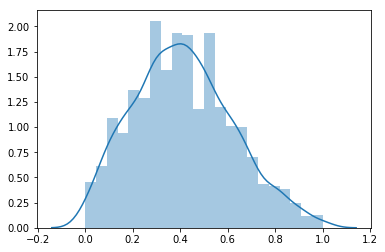

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(correct_guesses)
plt.show()

In [62]:
print("The ratio of correctly guessed papers is {:.2f}".format(100*correct_guesses.mean()))

The ratio of correctly guessed papers is 41.19


As can be seen the fraction of correctly guessed articles is approximately 40% +- 20%. This means that over say 10 articles provided by te reccomender system at least 4+-2 are related to the input article. Obviously this type of evaluation has some limitations; due to the fact that it is not completely true that all the cited articles are relevant, or that some of the articles provided by the reccomender system might be relevant, even if not cited. This approach anyway gives an approximate lower bound on how good the reccomender system works, and can help us to design the application that we are trying to build. Say in fact that we want the app to provide at least between 1 and 3 relevant article to the writer, than we can tune the application to provide 8 articles, so that we will be more or less confident (68% confident) that at least 3 of those are related to the user work.

A separate problem that we need to consider, is that only a fraction of the cited papers can be found on the arXiv. It would be interesting to consider what results we would get with more available resources.

Obviously this model is takeing into consideration all the classes. Better results can be achieved by restricting to consider specific classes.